# MNIST number classification

### Load modules

In [1]:
import tensorflow as tf
import numpy as np
import sys
import os

from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt

%matplotlib inline

### Load data

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x_train = mnist.train.images
y_train = mnist.train.labels
x_test = mnist.test.images
y_test = mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Plot number

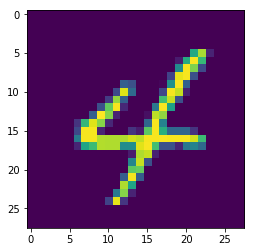

In [3]:
n_train = np.shape(x_train)[0]
idx = np.random.randint(n_train)
vector = x_train[idx]
img = np.reshape(vector, (28, 28))

plt.imshow(img)

### TensorFlow and TensorBoard helper functions

In [4]:
def variable_summaries(var, scope='summaries'):
    with tf.name_scope(scope):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name='W')

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name='b')

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], 
                        padding='SAME', name='convolution')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], 
                          padding='SAME', name='max_pool')

def apply_conv(x, shape, summarize=True):
    W_conv = weight_variable(shape)
    b_conv = bias_variable([shape[-1]])
    h_conv = tf.nn.relu(conv2d(x, W_conv) + b_conv)
    h_pool = max_pool_2x2(h_conv)
    if summarize:
        variable_summaries(W_conv, "weights")
        variable_summaries(b_conv, "biases")
    return h_pool

### One CNN to rule them all

In [5]:
# reset graph (important for batch normalization and summary)
tf.reset_default_graph()

# placeholder
x_input = tf.placeholder(tf.float32, [None, 784])
y_input = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)

with tf.device("/cpu:0"):
    
    with tf.name_scope("reshape"):
        x_image = tf.reshape(x_input, [-1, 28, 28, 1])
        tf.summary.image('input', x_image, 3)
        
    with tf.name_scope("conv1"):
        h1 = apply_conv(x_image, [5, 5, 1, 32])
        
    with tf.name_scope("conv2"):
        h2 = apply_conv(h1, [5, 5, 32, 64])
            
    with tf.name_scope("fully_connected"):
        W = weight_variable([7 * 7 * 64, 1024])
        b = bias_variable([1024])
        h_flat = tf.reshape(h2, [-1, 7 * 7 * 64])
        h_relu = tf.nn.relu(tf.matmul(h_flat, W) + b)
        
    with tf.name_scope("dropout"):
        h_drop = tf.nn.dropout(h_relu, keep_prob) 
        
    with tf.name_scope("readout"):
        W2 = weight_variable([1024, 10])
        b2 = bias_variable([10])
        y_conv = tf.matmul(h_drop, W2) + b2
        
    with tf.name_scope("cross_entropy"):
        cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=y_input, 
                logits=y_conv))
        tf.summary.scalar('cross_entropy', cross_entropy)
        
    with tf.name_scope("optimization"):
        train_step = tf.train.AdamOptimizer().minimize(cross_entropy)
        
    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(y_input, axis=1)) 
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    merged = tf.summary.merge_all()
    init = tf.global_variables_initializer()

### Test graph architecture

In [6]:
%%time
with tf.Session() as sess:
    sess.run(init)
    xs, ys = mnist.test.images, mnist.test.labels
    feed_dict = {x_input: xs, y_input: ys, keep_prob: 1}
    __ = sess.run(merged, feed_dict=feed_dict)
    print(np.shape(__))

()
CPU times: user 19.3 s, sys: 1.28 s, total: 20.6 s
Wall time: 1.47 s


### Clean summaries folder

In [7]:
def clean_folder(path="./tensorflow_summaries/"):
    for file in os.listdir(path):
        filepath = path + file
        if os.path.isfile(filepath):
            os.remove(filepath)
            
clean_folder(path="./tensorflow_summaries/train/")
clean_folder(path="./tensorflow_summaries/test/")

### Train model [delete random sampling later]

In [8]:
%%time

# feed dict helper
def feed_dict(train=True, dropout=1):
    batch_size = 50
    if train:
        xs, ys = mnist.train.next_batch(batch_size)
        k = dropout
    else:
        xs, ys = mnist.test.images, mnist.test.labels
        k = 1
    return {x_input: xs, y_input: ys, keep_prob: dropout}

# dropout: keep probability
k = 0.5

# using graph for training
with tf.Session() as sess:
    sess.run(init)
    train_writer = tf.summary.FileWriter("./tensorflow_summaries/train", sess.graph)
    test_writer = tf.summary.FileWriter("./tensorflow_summaries/test")
    
    for i in range(2000):
        if i % 50 == 0:
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Acc at epoch %s: %s' % (i, acc))
        else:
            summary, __ = sess.run([merged, train_step], feed_dict=feed_dict(True, k))
            train_writer.add_summary(summary, i)
        
    # test
    out = sess.run(accuracy, feed_dict=feed_dict(False))
    print("Acc. on test: %f" % out)

Acc at epoch 0: 0.1142
Acc at epoch 50: 0.8961
Acc at epoch 100: 0.945
Acc at epoch 150: 0.9509
Acc at epoch 200: 0.9617
Acc at epoch 250: 0.9593
Acc at epoch 300: 0.9655
Acc at epoch 350: 0.9706
Acc at epoch 400: 0.9711
Acc at epoch 450: 0.9724
Acc at epoch 500: 0.976
Acc at epoch 550: 0.9777
Acc at epoch 600: 0.9804
Acc at epoch 650: 0.9776
Acc at epoch 700: 0.9794
Acc at epoch 750: 0.979
Acc at epoch 800: 0.9836
Acc at epoch 850: 0.9829
Acc at epoch 900: 0.9786
Acc at epoch 950: 0.9795
Acc at epoch 1000: 0.9839
Acc at epoch 1050: 0.9845
Acc at epoch 1100: 0.9835
Acc at epoch 1150: 0.982
Acc at epoch 1200: 0.9846
Acc at epoch 1250: 0.9843
Acc at epoch 1300: 0.9852
Acc at epoch 1350: 0.9841
Acc at epoch 1400: 0.9828
Acc at epoch 1450: 0.981
Acc at epoch 1500: 0.983
Acc at epoch 1550: 0.9845
Acc at epoch 1600: 0.9845
Acc at epoch 1650: 0.9817
Acc at epoch 1700: 0.9853
Acc at epoch 1750: 0.983
Acc at epoch 1800: 0.9879
Acc at epoch 1850: 0.9867
Acc at epoch 1900: 0.986
Acc at epoch 1950